# Solar insolation prediction

**Project Description:** Prediction of solar insolation for photovoltaic power station.

**Dataset Description:** 16503 rows × 17 columns.

## Import libraries

In [1]:
import math
import sys
from collections import Counter
from itertools import chain, combinations

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import xgboost as xgb
from scipy.stats import ttest_ind
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import f_classif


print('Python:'.ljust(16), sys.version.split('\n')[0])
print('Numpy:'.ljust(16), np.__version__)
print('Pandas:'.ljust(16), pd.__version__)
print('scikit-learn:'.ljust(16), sklearn.__version__)
print('xgboost:'.ljust(16), xgb.__version__)

Python:          3.7.10 | packaged by conda-forge | (default, Feb 19 2021, 16:07:37) 
Numpy:           1.19.5
Pandas:          1.3.2
scikit-learn:    0.23.2
xgboost:         1.4.2


## Read file to dataframe

In [2]:
# Read
df = pd.read_csv('/kaggle/input/solarinsolation/38.csv')

# Show info
df.info()
print()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16503 entries, 0 to 16502
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   date_time_clouds          16503 non-null  object 
 1   clouds                    16503 non-null  float64
 2   station_id                16503 non-null  int64  
 3   insolation_value          16491 non-null  float64
 4   power_value               16503 non-null  float64
 5   minutes_of_daylight       16503 non-null  float64
 6   part_of_the_daylight      16503 non-null  float64
 7   morning                   16503 non-null  int64  
 8   afternoon                 16503 non-null  int64  
 9   evening                   16503 non-null  int64  
 10  angle                     16503 non-null  float64
 11  altitude                  16503 non-null  float64
 12  month                     16503 non-null  int64  
 13  insolation_max            16503 non-null  float64
 14  insola

,date_time_clouds,clouds,station_id,insolation_value,power_value,minutes_of_daylight,part_of_the_daylight,morning,afternoon,evening,angle,altitude,month,insolation_max,insolation_ratio,cloud_insolation_product,cloud_altitude_product
0,2019-07-01 05:00:00,0.436559,38,21.286000,0.057757,934.0,0.034261,1,0,0,23.120484,4.011289,7,36.614734,0.581351,15.984497,1.751165
1,2019-07-01 05:30:00,0.528763,38,46.264242,0.377800,934.0,0.066381,1,0,0,23.120484,8.743461,7,98.130755,0.471455,51.887956,4.623223
2,2019-07-01 06:00:00,0.620968,38,96.786046,0.778110,934.0,0.098501,1,0,0,23.120484,13.663870,7,171.787725,0.563405,106.674636,8.484823
3,2019-07-01 06:30:00,0.558333,38,152.763385,1.312607,934.0,0.130621,1,0,0,23.120484,18.732890,7,253.762202,0.601994,141.683896,10.459197
4,2019-07-01 07:00:00,0.495699,38,183.816872,2.577917,934.0,0.162741,1,0,0,23.120484,23.913128,7,341.086305,0.538916,169.076115,11.853712
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16498,2021-05-31 17:30:00,0.476344,38,324.180588,22.788333,921.0,0.847991,0,0,1,21.898483,21.996802,5,338.678660,0.957192,161.327577,10.478047
16499,2021-05-31 18:00:00,0.433871,38,227.321731,14.120625,921.0,0.880565,0,0,1,21.898483,16.817957,5,250.239742,0.908416,108.571759,7.296823
16500,2021-05-31 18:30:00,0.391129,38,145.846393,7.579000,921.0,0.913138,0,0,1,21.898483,11.752105,5,165.822686,0.879532,64.858067,4.596589
16501,2021-05-31 19:00:00,0.348387,38,71.176491,4.043750,921.0,0.945711,0,0,1,21.898483,6.837747,5,88.367773,0.805458,30.786192,2.382183


## Set globals

In [3]:
# G L O B A L   C O N S T A N T S
# Random seed
RANDOM_SEED = 42
# Target feature
TARGET = 'insolation_value'
# ID feature
IDENT = 'ts'
# Binary feature to separate train and test data
TRAIN = 'TRAIN'
# Feature of random numbers
RANDOM = 'RANDOM'
# Fraction of data reserved for test
TEST_SIZE = 0.15

## Format dataframe
- Delete 'station_id' feature because it has only one unique value.
- Delete 'clouds' feature because we will not know it while predicting (but we can predict it too).
- Delete 'insolation_max', 'insolation_ratio', 'cloud_insolation_product' and 'cloud_altitude_product' because they are depend on 'insolation_value' and 'clouds' features.
- Delete 'power_value' feature because it has some unknown factors to produce power from solar energy. Therefor we will use 'insolation_value' as target variable.
- Delete 'minutes_of_daylight' feature because it has strong correlation with 'angle' feature.

In [4]:
def format_dataframe(df):
    # Drop useless features
    df.drop([
        'station_id',
        'clouds',
        'power_value',
        'insolation_max',
        'insolation_ratio',
        'cloud_insolation_product',
        'cloud_altitude_product',
        'minutes_of_daylight',
    ], axis=1, inplace=True)
    
    # Rename dataframe columns
    df.rename(columns={'date_time_clouds': IDENT}, inplace=True)

    # Convert IDENT column to datetime type
    df[IDENT] = pd.to_datetime(df[IDENT])
    
    # Sort dataframe
    df.sort_values(by=IDENT, inplace=True)
    
    # Drop duplicates
    df.drop(df.loc[df.duplicated(IDENT)].index, inplace=True)
    
    # Set index
    df.set_index(IDENT, inplace=True)
    
    # Fill or drop missing values
    df.dropna(subset=[TARGET], inplace=True)
#     df.fillna(method='ffill', inplace=True)

    # Form feature to separate train and test parts
    # Test part should be at the tail because we deal with time series
    start_test_index = int(df.shape[0] * (1-TEST_SIZE))
    start_test_index = df.index[start_test_index]
    df[TRAIN] = True
    df.loc[start_test_index:, TRAIN] = False

## Feature engineering

In [5]:
def create_new_features(df):
    # Create feature of random numbers
    rng = np.random.default_rng(RANDOM_SEED)
    df[RANDOM] = rng.integers(1000000, size=(df.shape[0]))

## Analize dataframe

In [6]:
df = pd.read_csv('/kaggle/input/solarinsolation/38.csv')
format_dataframe(df)
create_new_features(df)

In [7]:
df.info()
print()
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16383 entries, 2019-07-01 05:00:00 to 2021-05-31 19:30:00
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   insolation_value      16383 non-null  float64
 1   part_of_the_daylight  16383 non-null  float64
 2   morning               16383 non-null  int64  
 3   afternoon             16383 non-null  int64  
 4   evening               16383 non-null  int64  
 5   angle                 16383 non-null  float64
 6   altitude              16383 non-null  float64
 7   month                 16383 non-null  int64  
 8   TRAIN                 16383 non-null  bool   
 9   RANDOM                16383 non-null  int64  
dtypes: bool(1), float64(4), int64(5)
memory usage: 1.8 MB



,insolation_value,part_of_the_daylight,morning,afternoon,evening,angle,altitude,month,TRAIN,RANDOM
ts,,,,,,,,,,
2019-07-01 05:00:00,21.286000,0.034261,1,0,0,23.120484,4.011289,7,True,89250
2019-07-01 05:30:00,46.264242,0.066381,1,0,0,23.120484,8.743461,7,True,773956
2019-07-01 06:00:00,96.786046,0.098501,1,0,0,23.120484,13.663870,7,True,654571
2019-07-01 06:30:00,152.763385,0.130621,1,0,0,23.120484,18.732890,7,True,438878
2019-07-01 07:00:00,183.816872,0.162741,1,0,0,23.120484,23.913128,7,True,433015


**Declare quantity, ordinal and categorical features**

In [8]:
def declare_features_type():
    """Declare target variable, quantity, ordinal and categorical features"""
    global categ_bin_cols, categ_many_cols, categ_multi_cols, categ_cols
    global quantity_cols, quantity_categ_cols, ordinal_cols, text_cols
    
    # Declare categorical features
    categ_bin_cols = [
        'morning',
        'afternoon',
        'evening',
    ]
    categ_many_cols = [
        'month',
    ]
    categ_multi_cols = [
    ]

    # Declare quantity features
    quantity_cols = [
        RANDOM,
        IDENT,
        'part_of_the_daylight',
        'angle',
        'altitude',
    ]

    # Declare categorized quantity features
    quantity_categ_cols = [
    ]

    # Declare ordinal features
    ordinal_cols = [
    ]

    # Declare text features
    text_cols = [
    ]

    # Update feature lists
    categ_bin_cols = [col for col in categ_bin_cols if col in df.columns]
    categ_many_cols = [col for col in categ_many_cols if col in df.columns]
    categ_multi_cols = [col for col in categ_multi_cols if col in df.columns]
    categ_cols = categ_bin_cols + categ_many_cols + categ_multi_cols
    quantity_cols = [col for col in quantity_cols if col in df.columns]
    quantity_categ_cols = [col for col in quantity_categ_cols if col in df.columns]
    ordinal_cols = [col for col in ordinal_cols if col in df.columns]
    text_cols = [col for col in text_cols if col in df.columns]
    
declare_features_type()

**View unique values**

In [9]:
# Print header
print(('Test:').rjust(30) + ('Train:').rjust(8) + ('All:').rjust(8))

# Find and show number of unique values of categorical features
categorical_unique_test = {}
categorical_unique_train = {}
categorical_unique = {}
for column in categ_cols:
    # Handle categ_multi_cols features
    if column in categ_multi_cols:
        categorical_unique_test[column] = pd.Series(Counter(chain.from_iterable(df.loc[df[column].notna() & ~df[TRAIN], column].str.split('|')))).sort_values(ascending=False)
        categorical_unique_train[column] = pd.Series(Counter(chain.from_iterable(df.loc[df[column].notna() & df[TRAIN], column].str.split('|')))).sort_values(ascending=False)
        categorical_unique[column] = pd.Series(Counter(chain.from_iterable(df.loc[df[column].notna(), column].str.split('|')))).sort_values(ascending=False)

    # Handle categ_bin_cols and categ_many_cols features
    else:
        categorical_unique_test[column] = pd.Series(Counter(chain.from_iterable(df.loc[df[column].notna() & ~df[TRAIN], column].apply(lambda x: [x])))).sort_values(ascending=False)
        categorical_unique_train[column] = pd.Series(Counter(chain.from_iterable(df.loc[df[column].notna() & df[TRAIN], column].apply(lambda x: [x])))).sort_values(ascending=False)
        categorical_unique[column] = pd.Series(Counter(chain.from_iterable(df.loc[df[column].notna(), column].apply(lambda x: [x])))).sort_values(ascending=False)

    # Show result
    print((column + ':').ljust(22)
          + str(len(categorical_unique_test[column])).rjust(8)
          + str(len(categorical_unique_train[column])).rjust(8)
          + str(len(categorical_unique[column])).rjust(8))

                         Test:  Train:    All:
morning:                     2       2       2
afternoon:                   2       2       2
evening:                     2       2       2
month:                       4      12      12


In [10]:
# Parameters
ALPHABET_ORDER = False

# Print header
print(('Test:').rjust(30) + ('Train:').rjust(8) + ('All:').rjust(8))

# Show unique values of categorical features
for column in categ_cols:
    print(column + ':')
    for i in categorical_unique[column].sort_index().index if ALPHABET_ORDER \
      else categorical_unique[column].index:
        print(str(i).ljust(22), end='')
        if i in categorical_unique_test[column].index:
            print(str(categorical_unique_test[column].at[i]).rjust(8), end='')
        else:
            print(str(0).rjust(8), end='')
        if i in categorical_unique_train[column].index:
            print(str(categorical_unique_train[column].at[i]).rjust(8), end='')
        else:
            print(str(0).rjust(8), end='')
        print(str(categorical_unique[column].at[i]).rjust(8))
    print()

                         Test:  Train:    All:
morning:
0                         1633    9379   11012
1                          825    4546    5371

afternoon:
0                         1680    9261   10941
1                          778    4664    5442

evening:
0                         1603    9210   10813
1                          855    4715    5570

month:
7                            0    1846    1846
5                          853     891    1744
8                            0    1721    1721
4                          770     799    1569
9                            0    1489    1489
3                          683     734    1417
10                           0    1353    1353
1                            0    1123    1123
11                           0    1105    1105
2                          152     935    1087
12                           0    1050    1050
6                            0     879     879



Not all months are in the test set!

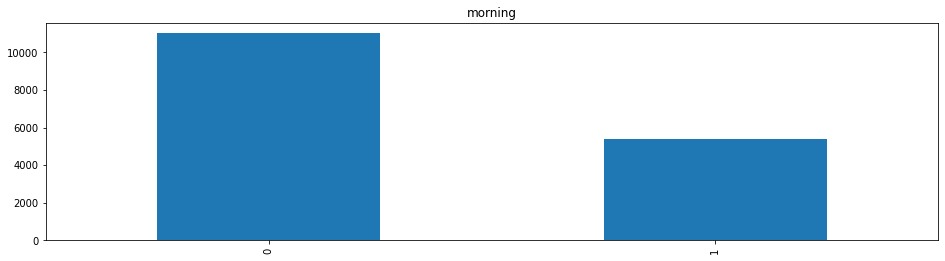

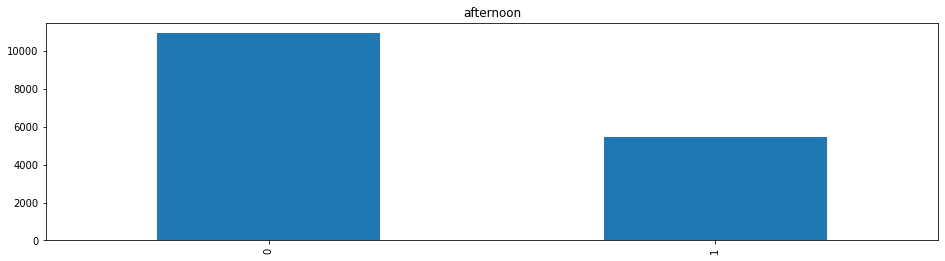

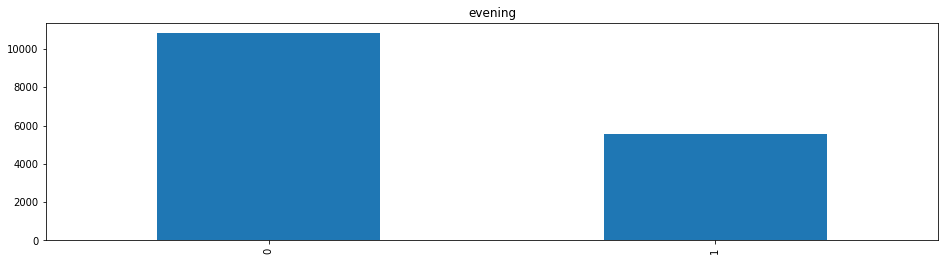

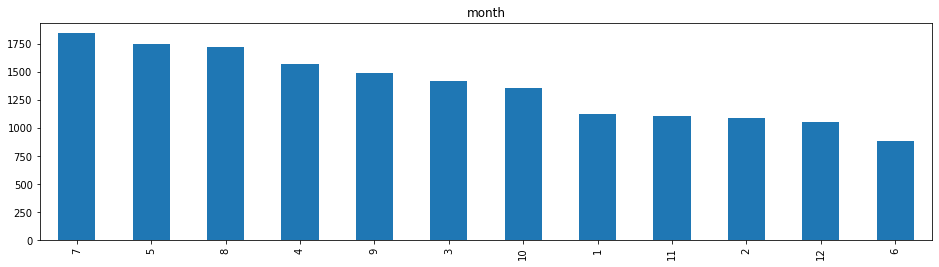

In [11]:
# Show distribution of categorical features
for column in categ_cols:
    categorical_unique[column].plot.bar(figsize=(16, 4), title=column)
    plt.show()

In [12]:
# Print header
print(('Test:').rjust(30) + ('Train:').rjust(8) + ('All:').rjust(8))

# Show number of unique values of quantity and ordinal features
for column in quantity_cols + quantity_categ_cols + ordinal_cols:
    print((column + ':').ljust(22)
          + (str(df.loc[~df[TRAIN], column].nunique()).rjust(8))
          + (str(df.loc[df[TRAIN], column].nunique()).rjust(8))
          + (str(df[column].nunique()).rjust(8)))

                         Test:  Train:    All:
RANDOM:                   2453   13836   16253
part_of_the_daylight:     2450    7924    7964
angle:                      99     366     366
altitude:                 2458    8804    8847


## Visualization

In [13]:
def show_scatters_vs_time(df, point_size=None, show_target=False):
    """Show scatters of quantity and ordinal features versus time"""
    # Define columns to plot
    if show_target:
        columns = sorted(quantity_cols + ordinal_cols + [TARGET])
    else:
        columns = sorted(quantity_cols + ordinal_cols)

    # Create figure with [rows x cols] graphs
    cols = 1
    rows = math.ceil((len(columns)) / cols)
    fig, axs = plt.subplots(rows, cols, figsize=(18, rows*5))

    # Plot graphs
    for i, column in enumerate(columns):
        if rows == 1:
            idx = i%cols
        elif cols == 1:
            idx = i%rows
        else:
            idx = (i//cols, i%cols)
        axs[idx].scatter(df.reset_index().loc[df.reset_index()[column].notna(), IDENT],
                         df.loc[df[column].notna(), column],
                         s=point_size)
        axs[idx].set_title(column)
        
        
def show_boxplots(df, show_target=False):
    """Show boxplots of quantity and ordinal features and check them for outliers existance"""
    # Define columns to plot
    if show_target:
        columns = sorted(quantity_cols + ordinal_cols + [TARGET])
    else:
        columns = sorted(quantity_cols + ordinal_cols)

    # Create figure with [rows x cols] graphs
    cols = 5
    rows = math.ceil((len(columns)) / cols)
    fig, axs = plt.subplots(rows, cols, figsize=(18, rows*5))

    # Plot graphs
    for i, column in enumerate(columns):
        if rows == 1:
            idx = i%cols
        else:
            idx = (i//cols, i%cols)
        axs[idx].boxplot(df.loc[df[column].notna(), column], showmeans=True)
        axs[idx].set_title(column)
        

def show_histograms(df, show_target=False):
    """Show distributions of quantity and ordinal features"""
    # Parameters
    DEFAULT_BINS = 50
    
    # Fill the list of bins' step if know it
    bin_step = {
        'numberOfDoors': 1,
        'productionDate': 1,
        'Владельцы': 1,
    }
    
    # Define columns to plot
    if show_target:
        columns = sorted(quantity_cols + ordinal_cols + [TARGET])
    else:
        columns = sorted(quantity_cols + ordinal_cols)

    # Create figure with [rows x cols] graphs
    cols = 4
    rows = math.ceil(len(columns)/cols)
    fig, axs = plt.subplots(rows, cols, figsize=(18, rows*4))

    # Plot graphs
    for i, column in enumerate(columns):
        # Calculate indices of subplots
        if rows == 1:
            idx = i%cols
        else:
            idx = (i//cols, i%cols)

        # Calculate number of bins and ranges
        if column in bin_step.keys():
            col_max = df[column].max()
            col_min = df[column].min()
            step = bin_step[column]
            offset = step / 2
            bins = int((col_max-col_min) / step) + 1
            range_ = (col_min - offset, col_max + offset)
        elif column in ordinal_cols:
            col_max = df[column].max()
            col_min = df[column].min()
            bins = int((col_max-col_min) * 2) + 1
            range_ = (col_min - 0.25, col_max + 0.25)
        else:
            bins = DEFAULT_BINS
            range_ = None

        # Plot
        axs[idx].hist(df.loc[df[column].notna(), column], bins, range_)
        axs[idx].set_title(column)
        
        
def show_scatters(df, point_size=None):
    """Show scatter plots of quantity and ordinal features from TARGET"""
    # Define columns to plot
    columns = sorted(quantity_cols + ordinal_cols)

    # Create figure with [rows x cols] graphs
    cols = 4
    rows = math.ceil((len(columns)) / cols)
    fig, axs = plt.subplots(rows, cols, figsize=(18, rows*4))

    # Plot graphs
    for i, column in enumerate(columns):
        if rows == 1:
            idx = i%cols
        else:
            idx = (i//cols, i%cols)
        axs[idx].scatter(x=df.loc[df[column].notna(), column],
                         y=df.loc[df[column].notna(), TARGET],
                         s=point_size)
        axs[idx].set_title(column)

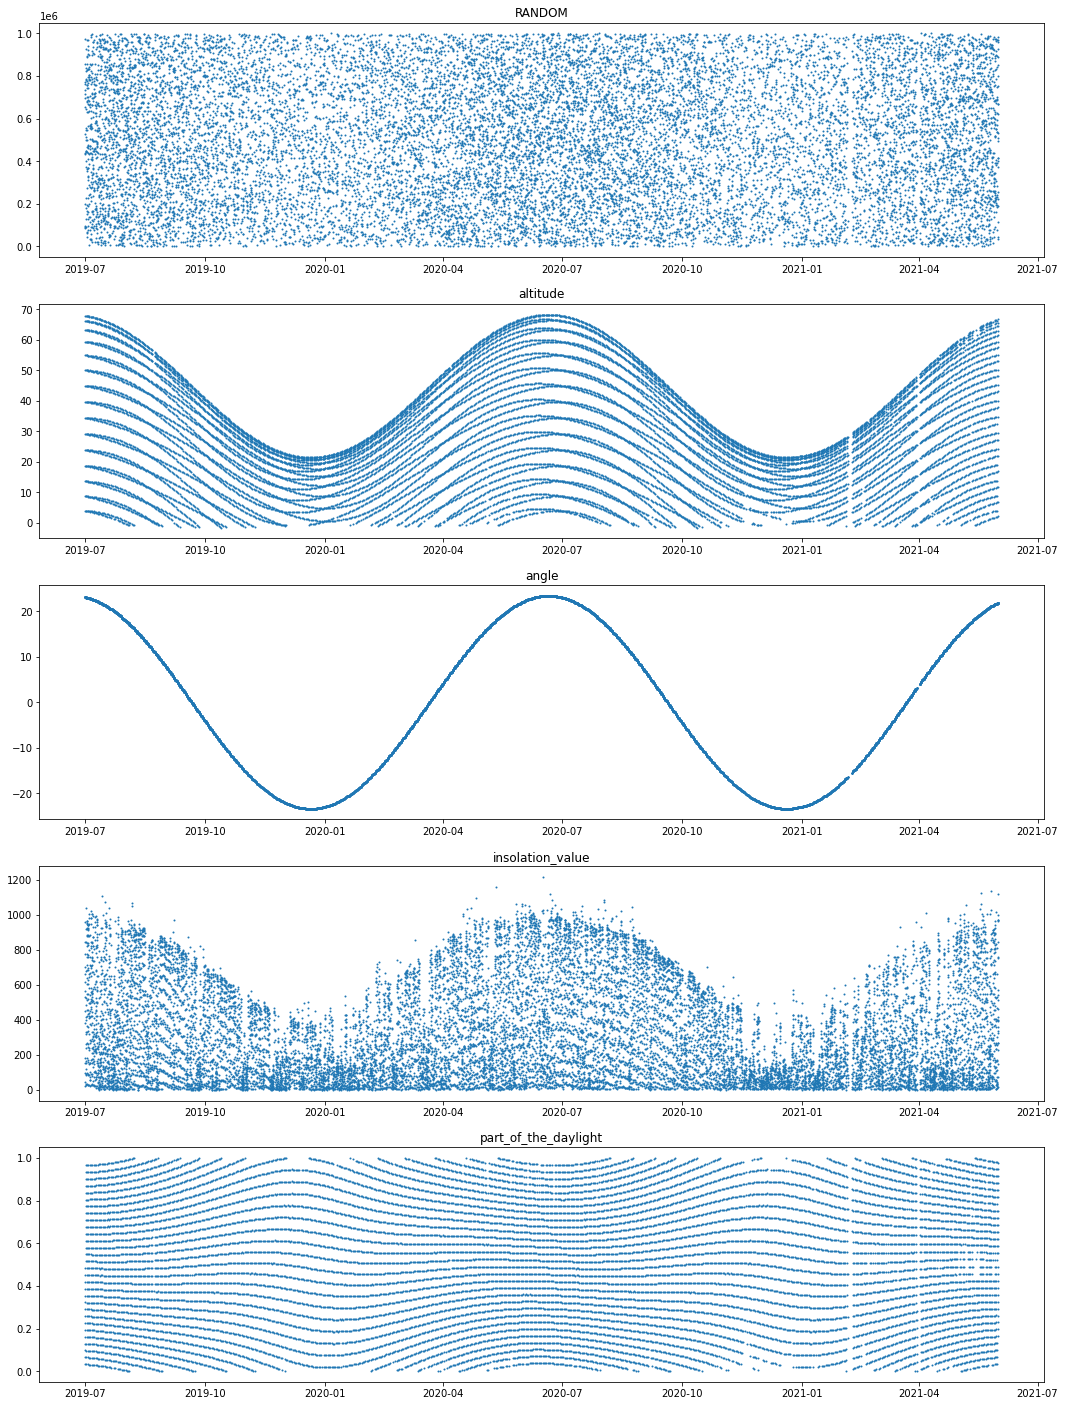

In [14]:
show_scatters_vs_time(df, point_size=1, show_target=True)

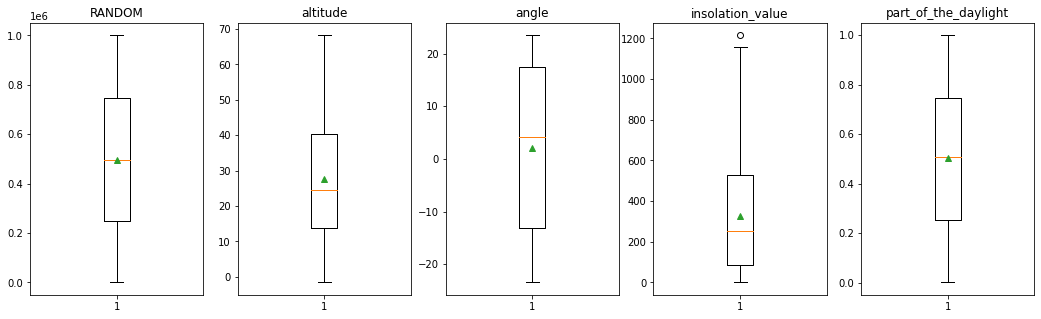

In [15]:
show_boxplots(df, show_target=True)

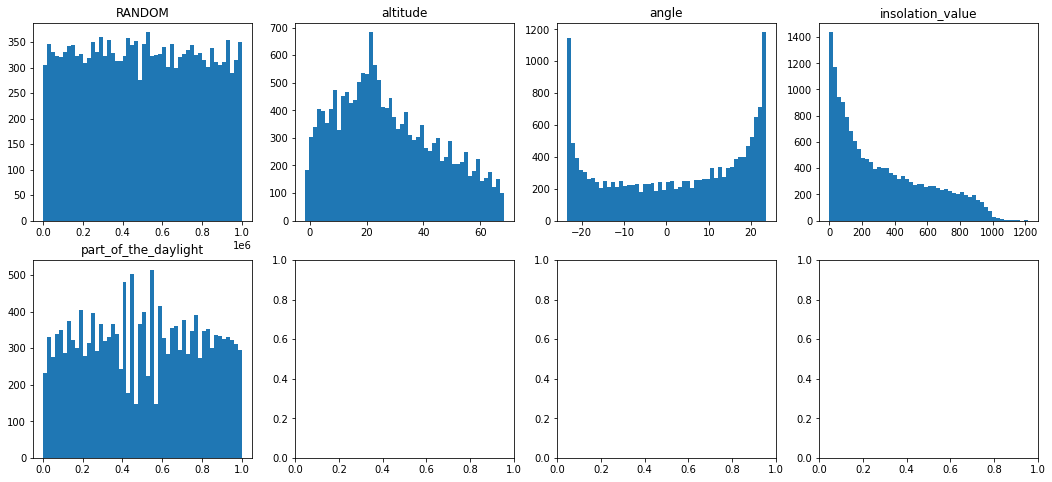

In [16]:
show_histograms(df, show_target=True)

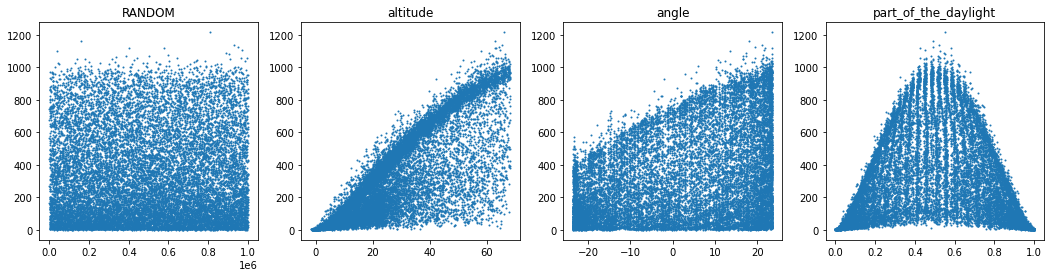

In [17]:
show_scatters(df, point_size=1)

## Significance analysis of features
### Analysis of quantity and ordinal features
#### Correlation analysis

In [18]:
# Calculate correlation matrix
corr_table = df.drop(TRAIN, axis=1).corr()
corr_table

,insolation_value,part_of_the_daylight,morning,afternoon,evening,angle,altitude,month,RANDOM
insolation_value,1.000000,-0.018720,-0.248366,0.518891,-0.269798,0.375670,0.802583,0.008075,0.004556
part_of_the_daylight,-0.018720,1.000000,-0.812575,-0.014992,0.820143,-0.005948,-0.012598,0.002317,0.002486
morning,-0.248366,-0.812575,1.000000,-0.492544,-0.501244,0.007074,-0.318381,-0.003319,0.000534
afternoon,0.518891,-0.014992,-0.492544,1.000000,-0.506180,-0.000759,0.642184,0.003770,-0.002050
evening,-0.269798,0.820143,-0.501244,-0.506180,1.000000,-0.006256,-0.323002,-0.000459,0.001509
angle,0.375670,-0.005948,0.007074,-0.000759,-0.006256,1.000000,0.473536,-0.129016,0.007960
altitude,0.802583,-0.012598,-0.318381,0.642184,-0.323002,0.473536,1.000000,-0.064602,0.003495
month,0.008075,0.002317,-0.003319,0.003770,-0.000459,-0.129016,-0.064602,1.000000,0.003628
RANDOM,0.004556,0.002486,0.000534,-0.002050,0.001509,0.007960,0.003495,0.003628,1.000000


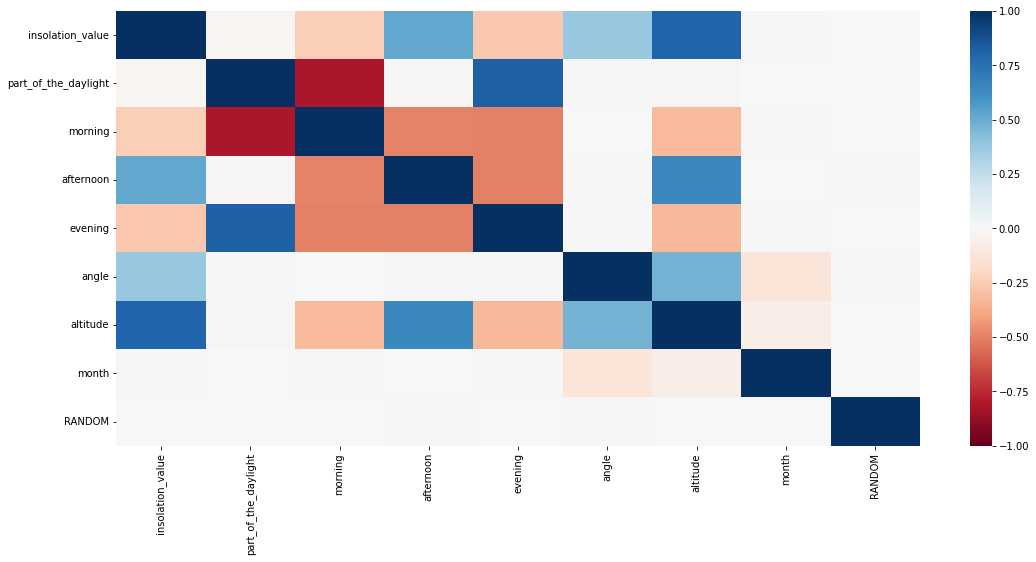

In [19]:
# Show correlation matrix
plt.subplots(figsize=(18, 8))
sns.heatmap(corr_table, vmin=-1, vmax=1, cmap="RdBu");

In [20]:
# Sort absolute correlation values with target variable
corr_table[TARGET].abs().sort_values(ascending=False)

insolation_value        1.000000
altitude                0.802583
afternoon               0.518891
angle                   0.375670
evening                 0.269798
morning                 0.248366
part_of_the_daylight    0.018720
month                   0.008075
RANDOM                  0.004556
Name: insolation_value, dtype: float64

#### Analysis of variance (ANOVA)

In [21]:
def anova_analysis(df):
    """Calculate and show significance of quantity and ordinal features based on ANOVA analysis"""
    columns = quantity_cols + ordinal_cols
    df_temp = df[columns + [TARGET]].dropna()
    return pd.Series(f_classif(df_temp[columns], df_temp[TARGET])[0], index=columns)

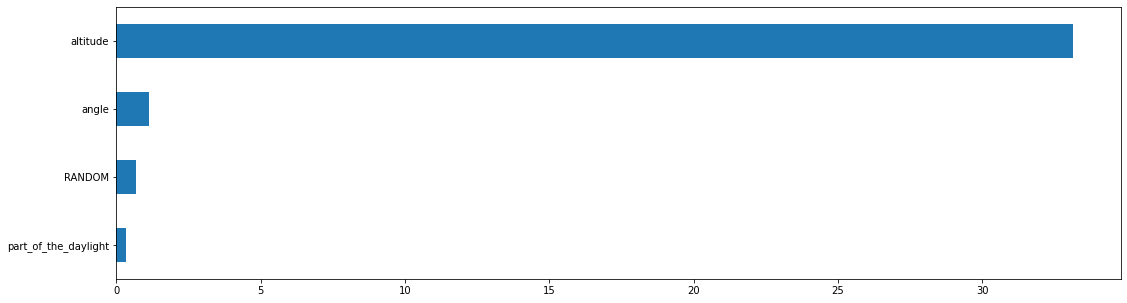

In [22]:
# Do ANOVA analysis
anova_analysis(df).sort_values().plot(figsize=(18, 5), kind='barh');

### Significance analysis of categorical features
#### Student's t-test

Using the Student's test, we will check whether there is a statistically significant difference in the distribution of the target variable for different values of categorical features. We test the null hypothesis that the distributions of the target variable over different values of the categorical variables are indistinguishable.

In [23]:
def hypothesis_testing(df):
    """Hypothesis testing of significance analysis"""
    NUM_OF_VALS = 10

    # Find not significant features
    mask = {}
    top_values = {}
    not_signif_columns = []
    for column in categ_cols:
        # Find top NUM_OF_VALS values
        top_values[column] = categorical_unique[column].index[:NUM_OF_VALS]

        # Find boolean masks
        mask[column] = {}
        for value in top_values[column]:
            if column in categ_multi_cols:
                mask[column][value] = (df[column].str.contains('(?:^|\|)'+value+'(?:$|\|)')) & (df[TARGET].notna())
            else:
                mask[column][value] = (df[column] == value) & (df[TARGET].notna())

        # Student t-test for value combinations
        combs = list(combinations(top_values[column], 2))
        for comb in combs:
            if ttest_ind(df.loc[mask[column][comb[0]], TARGET], 
                         df.loc[mask[column][comb[1]], TARGET]) \
                            .pvalue <= 0.05/len(combs): # Bonferroni correction
                break
        else:
            not_signif_columns.append(column)

    # Show result
    if len(not_signif_columns):
        print('Statistically significant differences have NOT been found for features:')
        for column in not_signif_columns:
            print(f"'{column}'")
    else:
        print('All categorical features have statistically significant difference with target')
        
    return (top_values, mask)


def boxplot_significance(df, top_values, mask):
    """Show boxplots of features to view significance"""
    # Create figure with [rows x cols] graphs
    rows = len(categ_cols)
    fig, axs = plt.subplots(rows, figsize=(18, rows*4))

    # Plot graphs
    for i, column in enumerate(categ_cols):
        if rows == 1:
            axs.boxplot([df.loc[mask[column][value], TARGET] for value in top_values[column]], showmeans=True)
            axs.set_title(column)
            axs.set_xticklabels(top_values[column], rotation=5)
            axs.set_ylabel(TARGET)
        else:
            axs[i].boxplot([df.loc[mask[column][value], TARGET] for value in top_values[column]], showmeans=True)
            axs[i].set_title(column)
            axs[i].set_xticklabels(top_values[column], rotation=5)
            axs[i].set_ylabel(TARGET)

All categorical features have statistically significant difference with target


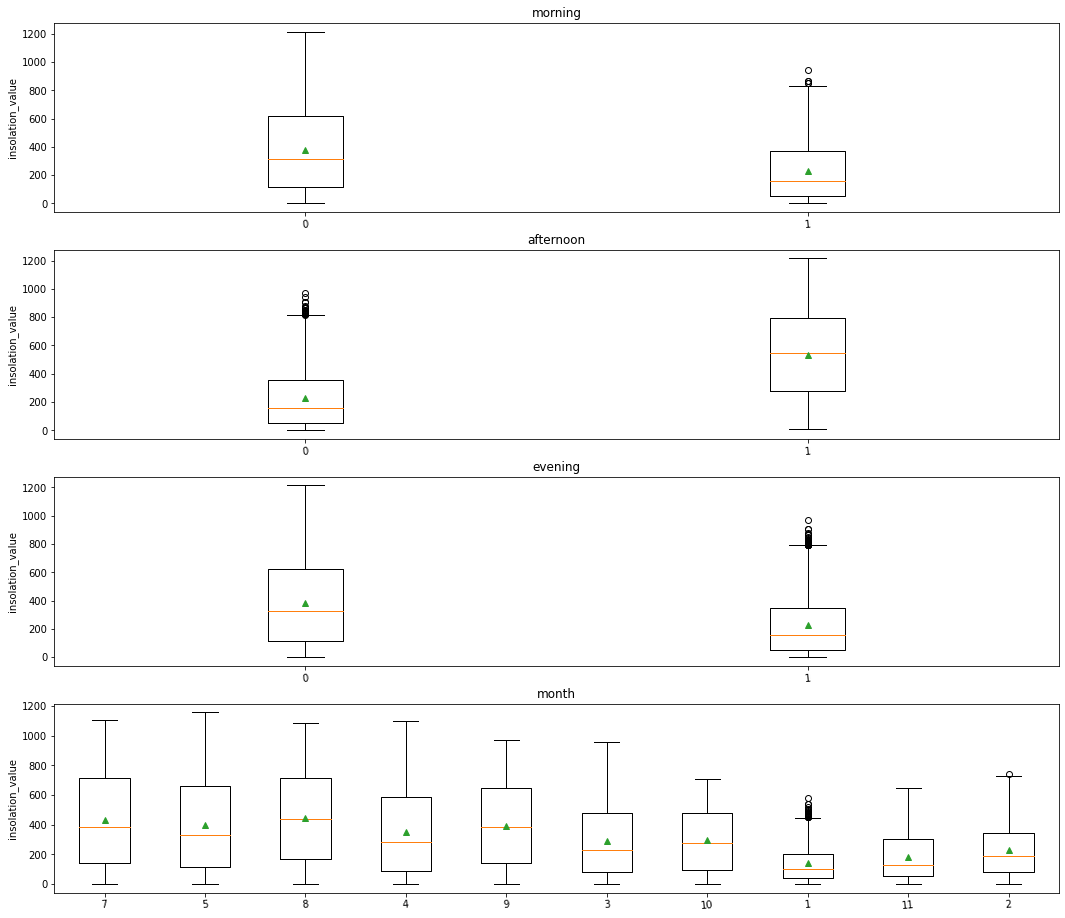

In [24]:
# Do hypothesis testing and show boxplots of significant features
top_values, mask = hypothesis_testing(df)
boxplot_significance(df, top_values, mask)

## Dummies generation

In [25]:
def generate_dummies(df, collinear_sens):
    """Dummies generation from categorical features
    
    collinear_sens is ML model collinearity sensitivity. It's either True or False.
    """
    # Generate dummies for categ_multi_cols
    for column in categ_multi_cols:
        df = pd.concat([df, df[column].str.get_dummies()], axis=1)
    df.drop(categ_multi_cols, axis=1, inplace=True)

    # Generate dummies for categ_many_cols
    df = pd.get_dummies(df, columns=categ_many_cols, drop_first=collinear_sens)
    
    return df

# Naive model implementation
The model predicts target as the average value relative to 'altitude' and 'angle' features.
## Prepare data

In [26]:
df = pd.read_csv('/kaggle/input/solarinsolation/38.csv')
format_dataframe(df)
create_new_features(df)
declare_features_type()
df.head()

,insolation_value,part_of_the_daylight,morning,afternoon,evening,angle,altitude,month,TRAIN,RANDOM
ts,,,,,,,,,,
2019-07-01 05:00:00,21.286000,0.034261,1,0,0,23.120484,4.011289,7,True,89250
2019-07-01 05:30:00,46.264242,0.066381,1,0,0,23.120484,8.743461,7,True,773956
2019-07-01 06:00:00,96.786046,0.098501,1,0,0,23.120484,13.663870,7,True,654571
2019-07-01 06:30:00,152.763385,0.130621,1,0,0,23.120484,18.732890,7,True,438878
2019-07-01 07:00:00,183.816872,0.162741,1,0,0,23.120484,23.913128,7,True,433015


## Split data

In [27]:
df_train = df.loc[df[TRAIN]]
df_test = df.loc[~df[TRAIN]]
print('Train shape: ', df_train.shape)
print('Test shape:  ', df_test.shape)

Train shape:  (13925, 10)
Test shape:   (2458, 10)


## Implement model

In [28]:
# Define map
bins = 20
map_ = df_train.groupby([pd.cut(df['angle'], bins).loc[df[TRAIN]],
                         pd.cut(df['altitude'], bins).loc[df[TRAIN]],
                        ])[TARGET].mean().dropna()

# Predict using values from the map
prediction = df_test.apply(lambda x: map_[(x['angle'], x['altitude'])], axis=1)
prediction

ts
2021-02-21 15:30:00    282.530623
2021-02-21 16:00:00    157.511131
2021-02-21 16:30:00    116.549473
2021-02-21 17:00:00     71.521481
2021-02-21 17:30:00     10.401838
                          ...    
2021-05-31 17:30:00    242.431647
2021-05-31 18:00:00    194.426329
2021-05-31 18:30:00     90.673816
2021-05-31 19:00:00     63.059265
2021-05-31 19:30:00     23.878421
Length: 2458, dtype: float64

## Test model

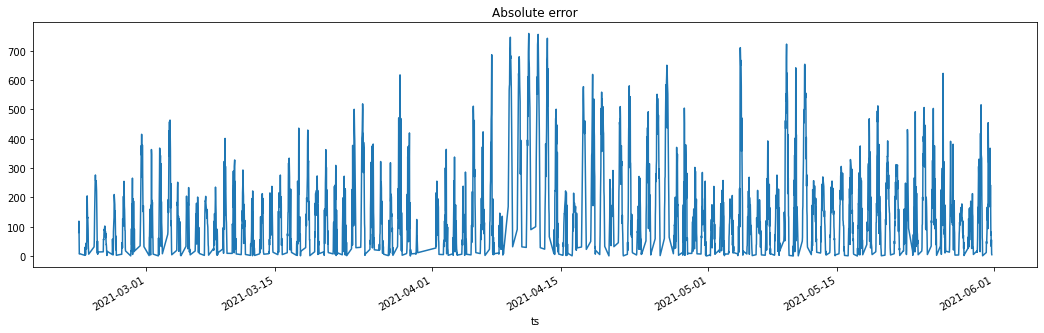

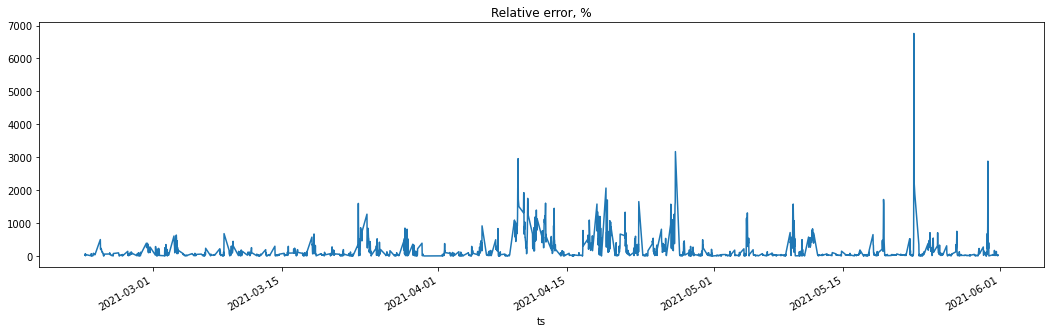

In [29]:
# Evaluate the model
abs_err = (df_test[TARGET] - prediction).abs()
rel_err = 100 * (abs_err / df_test[TARGET])
mae_score = np.mean(abs_err)
mape_score = np.mean(rel_err)
wrae_score = 100 * (abs_err.sum() / df_test[TARGET].sum())
rmse_score = mean_squared_error(df_test[TARGET], prediction, squared=False)

# Show error plots
abs_err.plot(figsize=(18, 5), title='Absolute error')
plt.show()
rel_err.plot(figsize=(18, 5), title='Relative error, %');

In [30]:
# Show result
print(f"Naive model MAE: {mae_score:0.0f}")
print(f"Naive model MAPE: {mape_score:0.2f} %")
print(f"Naive model whole relative AE: {wrae_score:0.2f} %")
print(f"Naive model RMSE: {rmse_score:0.0f}")

Naive model MAE: 169
Naive model MAPE: 162.99 %
Naive model whole relative AE: 53.18 %
Naive model RMSE: 229


The MAPE metric is high because the target variable has values close to zero.

# Classic ML model implementation
## Prepare data

In [31]:
df = pd.read_csv('/kaggle/input/solarinsolation/38.csv')
format_dataframe(df)
create_new_features(df)
declare_features_type()
df = generate_dummies(df, collinear_sens=False)
df.head()

,insolation_value,part_of_the_daylight,morning,afternoon,evening,angle,altitude,TRAIN,RANDOM,month_1,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
ts,,,,,,,,,,,,,,,,,,,,,
2019-07-01 05:00:00,21.286000,0.034261,1,0,0,23.120484,4.011289,True,89250,0,...,0,0,0,0,1,0,0,0,0,0
2019-07-01 05:30:00,46.264242,0.066381,1,0,0,23.120484,8.743461,True,773956,0,...,0,0,0,0,1,0,0,0,0,0
2019-07-01 06:00:00,96.786046,0.098501,1,0,0,23.120484,13.663870,True,654571,0,...,0,0,0,0,1,0,0,0,0,0
2019-07-01 06:30:00,152.763385,0.130621,1,0,0,23.120484,18.732890,True,438878,0,...,0,0,0,0,1,0,0,0,0,0
2019-07-01 07:00:00,183.816872,0.162741,1,0,0,23.120484,23.913128,True,433015,0,...,0,0,0,0,1,0,0,0,0,0


In [32]:
# Split data
X_train = df.loc[df[TRAIN]].drop([TARGET, TRAIN, RANDOM], axis=1).reset_index(drop=True)
X_test = df.loc[~df[TRAIN]].drop([TARGET, TRAIN, RANDOM], axis=1).reset_index(drop=True)
y_train = df.loc[df[TRAIN], TARGET].reset_index(drop=True)
y_test = df.loc[~df[TRAIN], TARGET].reset_index(drop=True)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)

## Implement and test model

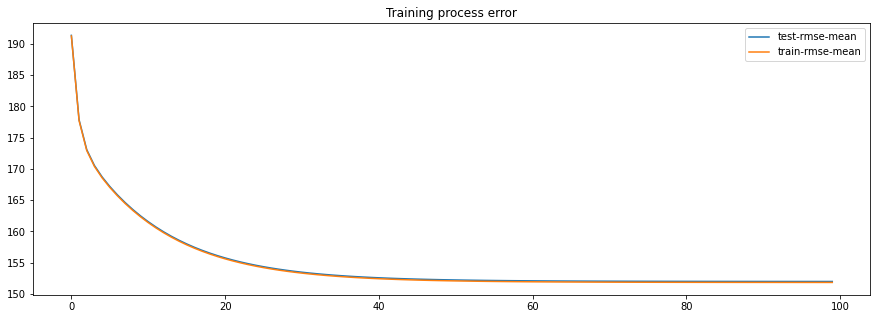

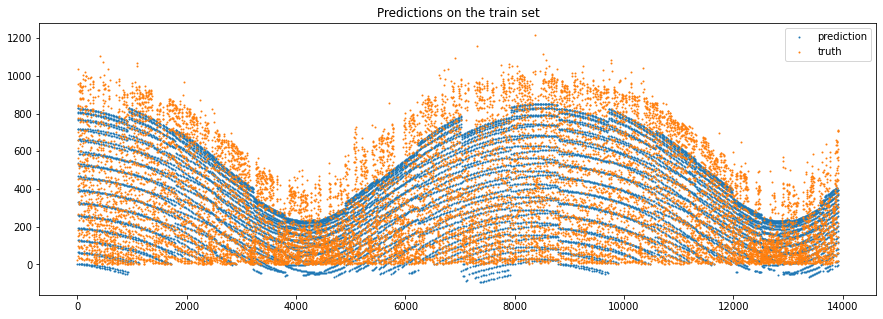

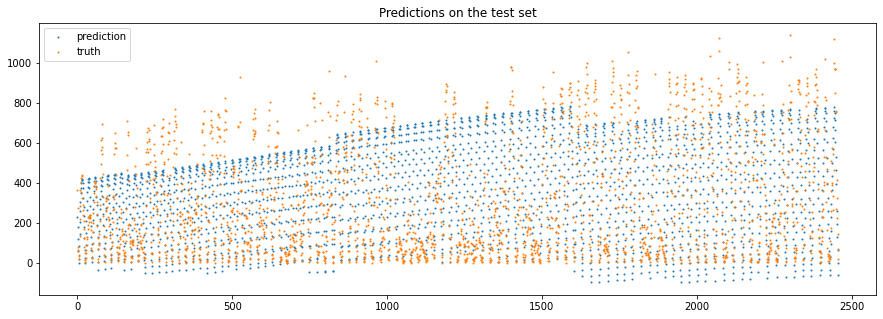

In [33]:
# Set parameters
params = {'objective': 'reg:squarederror',
          'booster': 'gblinear',}
trees = 100

# Train xgboost with optimal number of trees, based on cross validation
cv = xgb.cv(params, dtrain, metrics=('rmse'), nfold=10, num_boost_round=trees)
bst = xgb.train(params, dtrain, num_boost_round=cv['test-rmse-mean'].argmin())

# Show plots of training process
cv.plot(y=['test-rmse-mean', 'train-rmse-mean'], figsize=(15, 5), title='Training process error')

# Show predictions on the train set
prediction_train = bst.predict(dtrain)
plt.figure(figsize=(15, 5))
plt.scatter(x=range(prediction_train.shape[0]), y=prediction_train, s=1, label='prediction')
plt.scatter(x=range(y_train.shape[0]), y=y_train, s=1, label='truth')
plt.title("Predictions on the train set")
plt.legend()

# Show predictions on the test set
prediction_test = bst.predict(dtest)
plt.figure(figsize=(15, 5))
plt.scatter(x=range(prediction_test.shape[0]), y=prediction_test, s=1, label='prediction')
plt.scatter(x=range(y_test.shape[0]), y=y_test, s=1, label='truth')
plt.title("Predictions on the test set")
plt.legend();

In [34]:
# Show result
rmse_score = round(mean_squared_error(y_test, prediction_test, squared=False))
print(f"XGBoost model RMSE: {rmse_score}")

XGBoost model RMSE: 219


## Conclusions
Модель на основе XGBoost дала чуть лучший результат по сравнению с наивной моделью (RMSE равно 219 и 229 соответственно).

Что еще можно сделать для улучшения метрики:
- предсказывать признак 'clouds' (данный признак не использовался, так как мы не можем знать его значений в будущем);
- использовать полиномиальные признаки;
- использовать признаки tsfresh;
- использовать признаки задержки (lags);
- оптимизировать гиперпараметры модели XGBoost;
- построить модель на основе SARIMA;
- построить модель на основе RNN;
- использовать stacking моделей.